# Functional API model : SPVGGNet

### Imports

In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Conv2D, Activation, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.keras.models import Sequential

### Instanciate GPU

In [7]:
#use gpu
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


### Process data

In [8]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('original data type : ', X_train.dtype)
print('original data range [', np.min(X_train), ',', np.max(X_train),']')

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0

print('\nconverted data type : ', X_train.dtype)
print('converted data range [', np.min(X_train), ',', np.max(X_train),']')

print('\ntraining data shape : ', X_train.shape)
print('testing data shape  : ', X_test.shape)

original data type :  uint8
original data range [ 0 , 255 ]

converted data type :  float32
converted data range [ 0.0 , 1.0 ]

training data shape :  (50000, 32, 32, 3)
testing data shape  :  (10000, 32, 32, 3)


In [9]:
n_classes = 10
Y_train = utils.to_categorical(y_train, n_classes)
Y_test = utils.to_categorical(y_test, n_classes)
print(Y_train[:10])

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


### Create model

In [10]:
input_shape = X_train.shape[1:]

inputs = Input(shape=input_shape)
x = inputs
for block in range(4):  # 4 blocks
    for layer in range(3):  # 3 Conv2D → relu → BN
        x = Conv2D(64, (3, 3), padding='same', strides=1, name=f'conv2d_{block*3+layer}')(x)
        x = Activation('relu', name=f'activation_{block*3+layer}')(x)
        x = BatchNormalization(name=f'batch_normalization_{block*3+layer}')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=2, name=f'max_pooling2d_{block}')(x)
    x = Dropout(0.3, name=f'dropout_{block}')(x)

flatten = Flatten(name='flatten')(x)
dense = Dense(256, activation='relu', name='dense_1')(flatten)
dropout = Dropout(0.3, name='dropout_final')(dense)
outputs = Dense(n_classes, activation='softmax', name='outputs')(dropout)

model = Model(inputs, outputs)


model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_0 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 activation_0 (Activation)   (None, 32, 32, 64)        0         
                                                                 
 batch_normalization_0 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 activation_1 (Activation)   (None, 32, 32, 64)        0         
                                                             

### Train model

In [11]:
E = 10                # number of epochs
B = 64                # batch size
V = 0.2               # validation split

checkpoint_callback = ModelCheckpoint(
    'best_model_b.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

log = model.fit(X_train, Y_train, batch_size=B, epochs=E,
               verbose=1, validation_data=(X_test, Y_test),callbacks=[checkpoint_callback])

Epoch 1/10
782/782 [==============================] - ETA: 0s - loss: 1.7332 - accuracy: 0.3687
Epoch 1: val_accuracy improved from -inf to 0.47430, saving model to best_model_b.h5
782/782 [==============================] - 58s 68ms/step - loss: 1.7332 - accuracy: 0.3687 - val_loss: 1.4267 - val_accuracy: 0.4743
Epoch 2/10
782/782 [==============================] - ETA: 0s - loss: 1.2044 - accuracy: 0.5699
Epoch 2: val_accuracy improved from 0.47430 to 0.55230, saving model to best_model_b.h5
782/782 [==============================] - 50s 64ms/step - loss: 1.2044 - accuracy: 0.5699 - val_loss: 1.2714 - val_accuracy: 0.5523
Epoch 3/10
782/782 [==============================] - ETA: 0s - loss: 0.9800 - accuracy: 0.6562
Epoch 3: val_accuracy improved from 0.55230 to 0.66000, saving model to best_model_b.h5
782/782 [==============================] - 113s 145ms/step - loss: 0.9800 - accuracy: 0.6562 - val_loss: 1.0051 - val_accuracy: 0.6600
Epoch 4/10
781/782 [============================>.

### Evaluate model

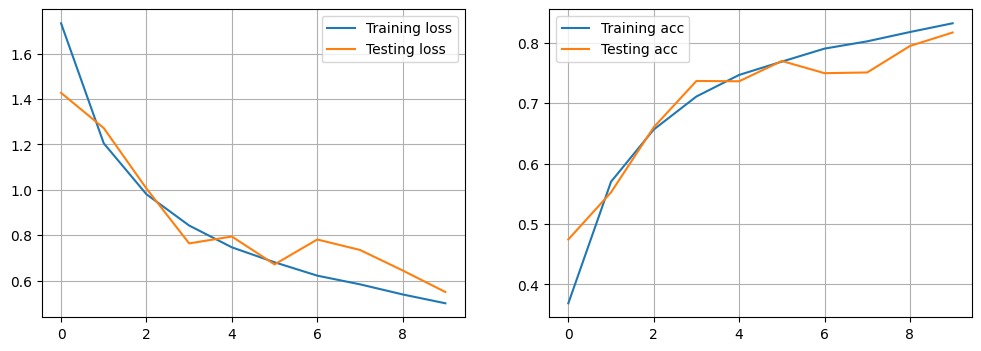

In [12]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(log.history['loss'], label='Training loss')
ax1.plot(log.history['val_loss'], label='Testing loss')
ax1.legend()
ax1.grid()
ax2.plot(log.history['accuracy'], label='Training acc')
ax2.plot(log.history['val_accuracy'], label='Testing acc')
ax2.legend()
ax2.grid()

In [14]:
train_acc = log.history["accuracy"]
loss_test, metric_test = model.evaluate(X_test, Y_test, verbose=0)
print(f'Train accuracy : {train_acc[-1]}')
print('Test accuracy:', metric_test)

Train accuracy : 0.832099974155426
Test accuracy: 0.8167999982833862
